# Notebook for calculating F1-scores
#### It requires results saved from running OBS_CMIP6_pcmciplus.ipynb

## Imports

In [3]:
import numpy as np
import utils as fk
from glob import glob
import pickle
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
import warnings
from tigramite import plotting as tp

/home/b/b380749/mambaforge/envs/Tigralevante/lib/python3.10/site-packages/tigramite-5.0.1.17-py3.10.egg/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/home/b/b380749/mambaforge/envs/Tigralevante/lib/python3.10/site-packages/tigramite-5.0.1.17-py3.10.egg/tigramite/../versions.py'
  warnings.warn(str(e))


#### Path for the results directory.
#### Notebook *" OBS_CMIP6_pcmciplus.ipynb "* should be run **first**

In [8]:
## Path for the results directory.
## First notebook (OBS_CMIP6_pcmciplus.ipynb) should be run first

pathobs='Results_DIR/ERSST_v5ERA20C_ERA5_1900_2014_tau_15/'
path='Results_DIR/'

## Same LE models we ran the PCMCI+ on
model_list=['ACCESS-ESM1-5','CESM2','CNRM-ESM2-1','CanESM5', 'EC-Earth3','GISS-E2-1-H','INM-CM5-0','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorCPM1','UKESM1-0-LL']


In [5]:
#### Create dictionary to store everything from created results
cmip_dict={}
      
for model in model_list:
    cmip_dict[model]={}
    ensdirl=glob(path+model+'/*'+model+'*')
    ensdirl.sort()
    print(model)
    for em_file in ensdirl:
        em_str=em_file.split('/')[-1].split('_')[1].split('_')[-1]
        #print(em_str)
        regime_cmip_dict={'No_mask': [], 'AMV+': [], 'AMV-': [], 'PDV+':[], 'PDV-':[], 'InPhase':[], 'outphase':[],\
                    'PDVpAMVp': [], 'PDVpAMVm':[] , 'PDVmAMVp':[], 'PDVmAMVm':[] } 
        cmip_dict[model][em_str]=regime_cmip_dict
        for regimef in glob(em_file+'/*'):
            regname=regimef.split('/')[-1].split('_')[0]
            #print(regname) 
            if regname =='No':
                regname = 'No_mask'
            filematl=glob(regimef+'/*'+regname+'_val_matrix.npy')
            filepl=glob(regimef+'/*'+regname+'_p_matrix.npy')    
            filelinkl=glob(regimef+'/*'+regname+'_link_matrix.npy')
            #print(filematl)
            val_mat=np.load(filematl[0])
            p_mat=np.load(filepl[0])
            link_mat=np.load(filelinkl[0])
            cmip_dict[model][em_str][regname].append(val_mat) #0
            cmip_dict[model][em_str][regname].append(p_mat) #1
            cmip_dict[model][em_str][regname].append(link_mat) #2            
            

ACCESS-ESM1-5
CESM2
CNRM-ESM2-1
CanESM5
EC-Earth3
GISS-E2-1-H
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-LR
NorCPM1
UKESM1-0-LL


In [9]:
#### Add observation to the dictionary        

regime_obs_dict={'No_mask': [], 'AMV+': [], 'AMV-': [], 'PDV+':[], 'PDV-':[], 'InPhase':[], 'outphase':[],\
                    'PDVpAMVp': [], 'PDVpAMVm':[] , 'PDVmAMVp':[], 'PDVmAMVm':[]}       

for regime in regime_obs_dict.keys():
    filematl=glob(pathobs+regime+'*/*'+regime+'_val_matrix.npy')
    filepl=glob(pathobs+regime+'*/*'+regime+'_p_matrix.npy')    
    filelinkl=glob(pathobs+regime+'*/*'+regime+'_link_matrix.npy')
    val_mat=np.load(filematl[0])
    p_mat=np.load(filepl[0])
    link_mat=np.load(filelinkl[0])
    regime_obs_dict[regime].append(val_mat) #0
    regime_obs_dict[regime].append(p_mat) #1
    regime_obs_dict[regime].append(link_mat) #2
    #print(val_mat)
    #print(regime_obs_dict['No_mask'][2])
cmip_dict['OBS']=regime_obs_dict

In [10]:
#### Let's save the dictionary in the results directory
#### Optional


with open('Results_DIR/OBS_CMIP6_valplink_dict.pickle', 'wb') as handle:
    pickle.dump(cmip_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [11]:
loaded_pic= pickle.load(open("Results_DIR/OBS_CMIP6_valplink_dict.pickle", "rb"))

#loaded_pic=dict()
#loaded_pic=cmip_dict

###### F1-Score with respect to Reanalysis data

for modelens in loaded_pic.keys():
    if modelens == 'OBS':
        for regime in loaded_pic[modelens].keys(): 
            val=loaded_pic[modelens][regime][0]
            p=loaded_pic[modelens][regime][1]
            lin=loaded_pic[modelens][regime][2]
            matlist=[val,p,lin]
            matnames=['val_matrix','p_matrix', 'link_matrix']
            matdict=dict(zip(matnames, matlist))
            loaded_pic[modelens][regime]=dict()
            loaded_pic[modelens][regime]=matdict
            print('#########END: REFERENCE')
    else:
        for ens in loaded_pic[modelens].keys():
            for regime in loaded_pic[modelens][ens].keys():               
                
                if len(loaded_pic[modelens][ens][regime]) > 0:
                    val=loaded_pic[modelens][ens][regime][0]
                    p=loaded_pic[modelens][ens][regime][1]
                    lin=loaded_pic[modelens][ens][regime][2]
                    
                    precision, recall, TP, FP, FN, score, auto, count = fk.get_metric_f1(loaded_pic['OBS'][regime][1], loaded_pic[modelens][ens][regime][1], loaded_pic['OBS'][regime][0], loaded_pic[modelens][ens][regime][0], 0.05, tau_min=0, tau_diff=10, same_sign=True)
                    f1_list=[val,p,lin,precision, recall, TP, FP, FN, score, auto, count]
                    f1_names=['val_matrix','p_matrix', 'link_matrix', 'precision', 'recall', 'TP', 'FP', 'FN', 'score', 'auto', 'count']
                    f1_dict=dict(zip(f1_names,f1_list))
                    loaded_pic[modelens][ens][regime]=f1_dict




#########END: REFERENCE
#########END: REFERENCE
#########END: REFERENCE
#########END: REFERENCE
#########END: REFERENCE
#########END: REFERENCE
#########END: REFERENCE
#########END: REFERENCE
#########END: REFERENCE
#########END: REFERENCE
#########END: REFERENCE


In [12]:
score_dict={}
for modelens in loaded_pic.keys():
    if modelens == 'OBS':
        print('OBS: Ref')
    else:
        score_dict[modelens]={}

        for ens in loaded_pic[modelens].keys():
            score_dict[modelens][ens]={}
            for regime in loaded_pic[modelens][ens].keys():
                #print(modelens, ens, regime)
                #print()
                if type(loaded_pic[modelens][ens][regime]) == dict:
                    score_dict[modelens][ens][regime]=loaded_pic[modelens][ens][regime]['score']


OBS: Ref


In [13]:
reformed_dict = {}
for outerKey, innerDict in score_dict.items():
    for innerKey, values in innerDict.items():
        reformed_dict[(outerKey,
                       innerKey)] = values

df = pd.DataFrame.from_dict(reformed_dict)
df=df.transpose()
df.index = pd.MultiIndex.from_tuples(df.index, names=['CMIP6_LE', 'ensemble_member'])


In [14]:
df.rename(columns = {'No_mask':'Complete period', 'InPhase':'IN PHASE','outphase':'OUT OF PHASE'}, inplace = True)

In [15]:
def make_pretty(styler):
    styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="Reds")
    return styler

In [16]:
df.round(3).style.pipe(make_pretty)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

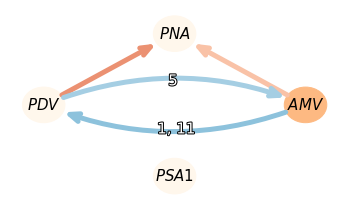

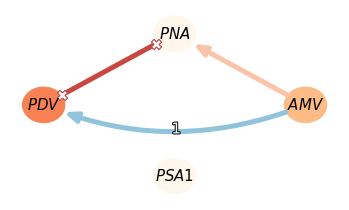

In [19]:
# Sanity Check: Plot causal graphs from Reanalysis and simulation
# with best F1-score during Out-of-phase regime.


var_names=['$AMV$','$PNA$','$PDV$','$PSA1$']


tp.plot_graph(    
    val_matrix=loaded_pic['OBS']['outphase']['val_matrix'],
    graph=loaded_pic['OBS']['outphase']['link_matrix'],
    var_names=var_names,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
    #save_name=out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_plt_causalgraph.png',
    node_label_size=15,
    link_label_fontsize=15,
    node_size=0.5,
    show_colorbar=False)
tp.plot_graph(    
    val_matrix=loaded_pic['MIROC6']['r20i1p1f1']['outphase']['val_matrix'],
    graph=loaded_pic['MIROC6']['r20i1p1f1']['outphase']['link_matrix'],
    var_names=var_names,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
    #save_name=out_dir+modelname+'_'+timestr+'_cvdp_'+regime+'_plt_causalgraph.png',
    node_label_size=15,
    link_label_fontsize=15,
    node_size=0.5,
    show_colorbar=False)

In [20]:
#### Here we prepare a new dataframe for only three regimes (complete period, in-phase and out-of-phase)
df_new = df[['Complete period','IN PHASE', 'OUT OF PHASE']]#,'AMV+','AMV-','PDV+','PDV-']]#,'PDVpAMVp','PDVpAMVm','PDVmAMVp', ]]


In [21]:
df_new =df_new.reset_index()

In [22]:
#pd.set_option("display.max_rows", None, "display.max_columns", None, 'precision',2)
melted=pd.melt(df_new, id_vars=["CMIP6_LE","ensemble_member"],
        var_name="Regime (period)", 
        value_name="F1-score")

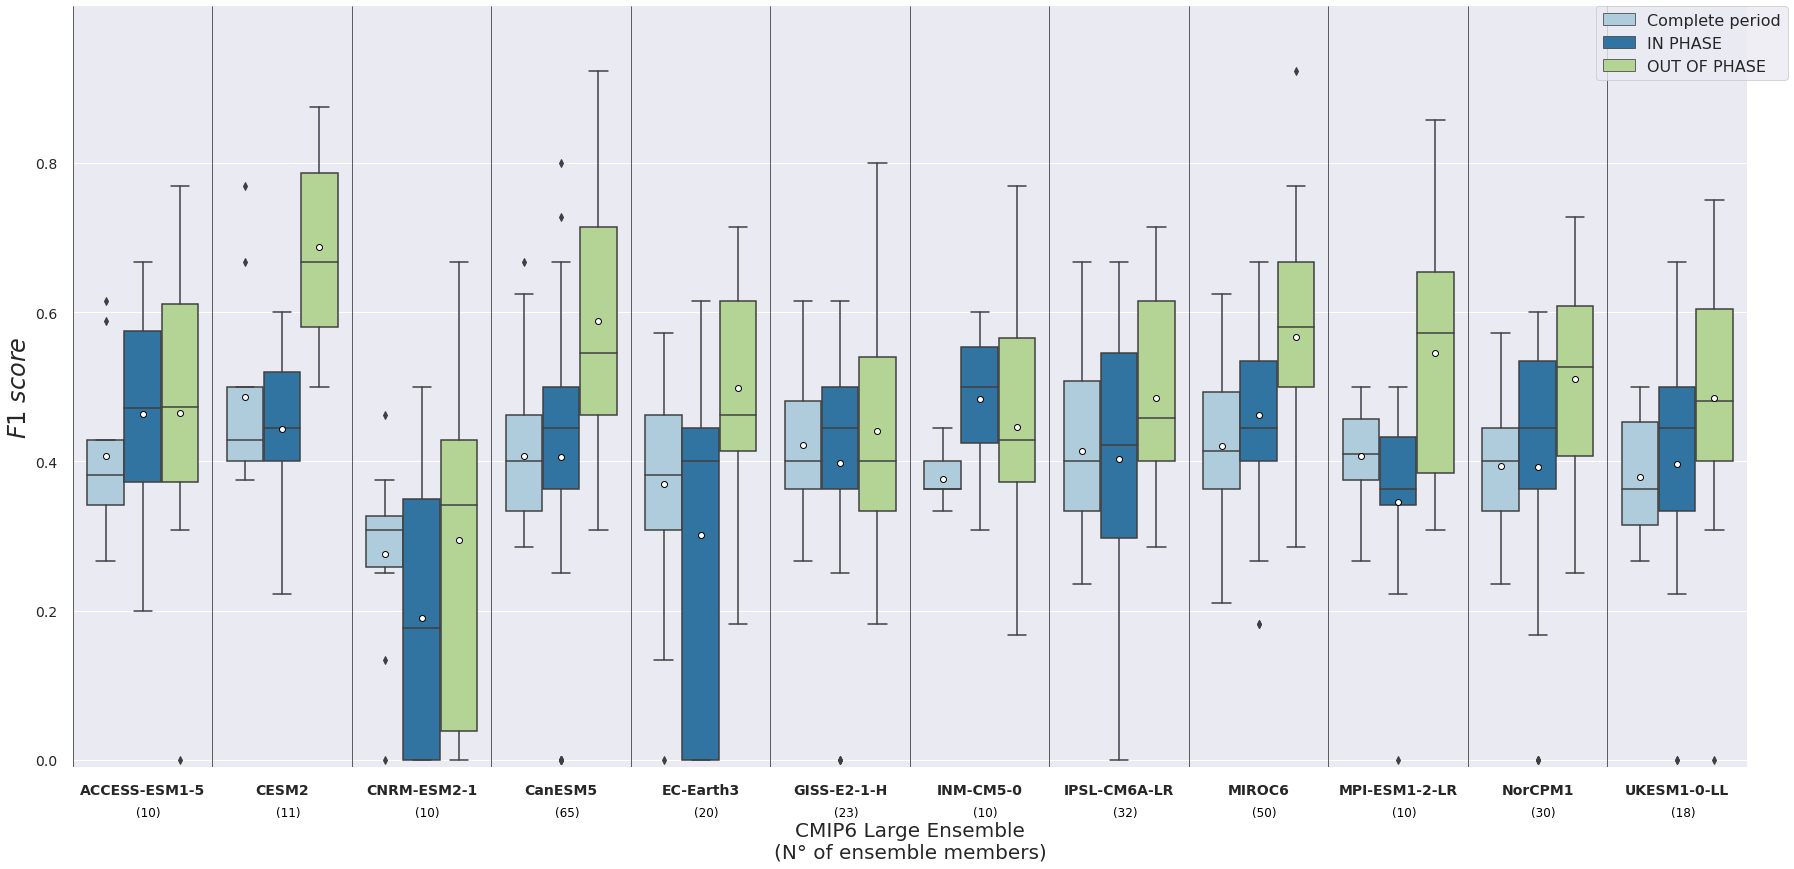

In [24]:
#import seaborn as sns
fig, ax = plt.subplots(figsize=(30,14))
#sns.color_palette("Set2", 20)
sns.set_theme(style="darkgrid", palette="Paired")

counts=melted.groupby(['CMIP6_LE']).count()/3

# Draw a nested boxplot to F1-scores  by regime and by CMIP6 LE
g=sns.boxplot(x="CMIP6_LE", y="F1-score",
            hue="Regime (period)", 
            data=melted, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})
yticks=g.get_yticks()
for xtick in g.get_xticks():
    ax.axvline(x=xtick-0.5, color='black', linewidth=0.6)
    g.text(xtick+0.04,-0.075, '('+str(int(counts['ensemble_member'][xtick]))+')', horizontalalignment='center',size='medium',color='black',weight='regular')

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel("$F1$ $score$",weight='normal',fontsize=24)
ax.set_xlabel(r"CMIP6 Large Ensemble""\n"r"(N° of ensemble members)",weight='normal',fontsize=20,labelpad=24)
sns.despine(offset=6, trim=True)
ax.set_ylim([-0.01, 1.01])
plt.xticks(fontsize=14, weight='bold')
plt.yticks(fontsize=14, weight='regular')

#plt.grid(True)
plt.legend(bbox_to_anchor=(0.91, 1), loc=2, prop={'size': 16}, borderaxespad=0.)
plt.savefig("Results_DIR/F1_3_regime_horizboxplot.png", dpi=300)
plt.show()

In [25]:
resu_dic=loaded_pic
f1_matrix=dict()
for regime in resu_dic['OBS'].keys():
    f1_matrix[regime]={}
    
    for modelens in resu_dic.keys():
        if modelens != 'OBS':
            f1_matrix[regime][modelens]={}
            for ens in resu_dic[modelens].keys(): 
                f1_matrix[regime][modelens][ens]={}
                if len(resu_dic[modelens][ens][regime]) > 0:
                    refval=resu_dic[modelens][ens][regime]['val_matrix']
                    refp=resu_dic[modelens][ens][regime]['p_matrix']
                    reflin=resu_dic[modelens][ens][regime]['link_matrix']
                    for othermodelens in resu_dic.keys():
                        if othermodelens != 'OBS':
                            f1_matrix[regime][modelens][ens][othermodelens]={}
                            for otherens in resu_dic[othermodelens].keys():
                                if (modelens == othermodelens) and (ens == otherens):
                                    #print(regime,modelens,ens)
                                    pass
                                else:
                                    if len(resu_dic[othermodelens][otherens][regime]) > 0:
                                        precision, recall, TP, FP, FN, score, auto, count = fk.get_metric_f1(refp, resu_dic[othermodelens][otherens][regime]['p_matrix'], refval, resu_dic[othermodelens][otherens][regime]['val_matrix'], 0.05, tau_min=0, tau_diff=10, same_sign=True)

                                        f1_matrix[regime][modelens][ens][othermodelens][otherens]=score
                                     #   print(modelens, othermodelens, ens, otherens, score)
                                    #else:
                                    #    print('other ens empty maybe', modelens, othermodelens, ens, otherens, len(resu_dic[othermodelens][otherens][regime]))





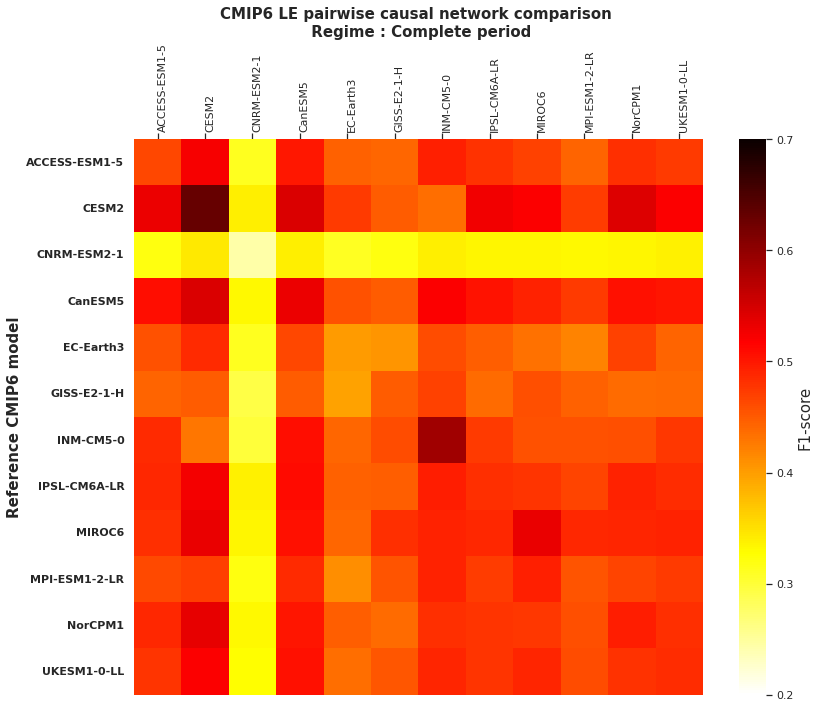

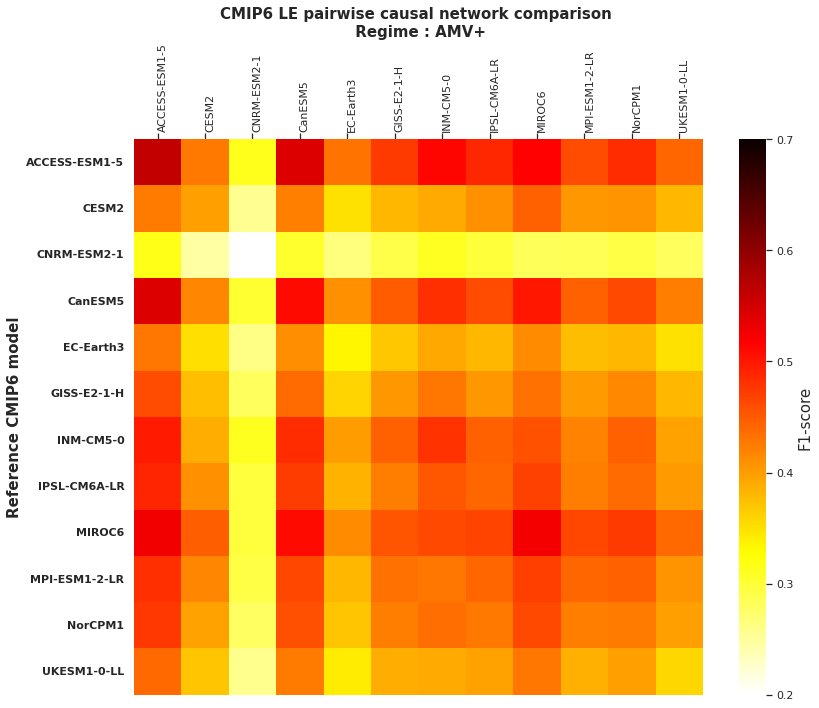

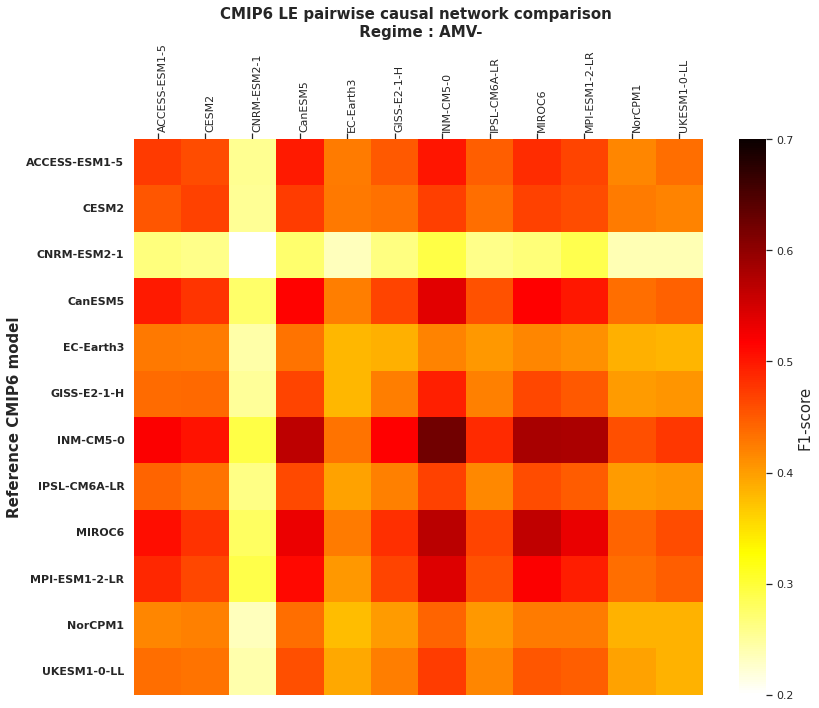

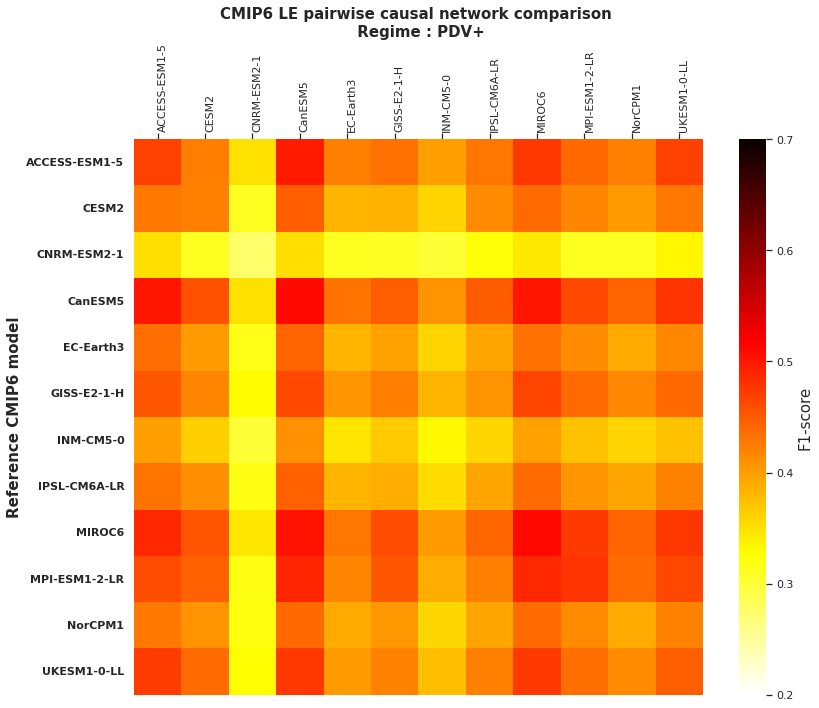

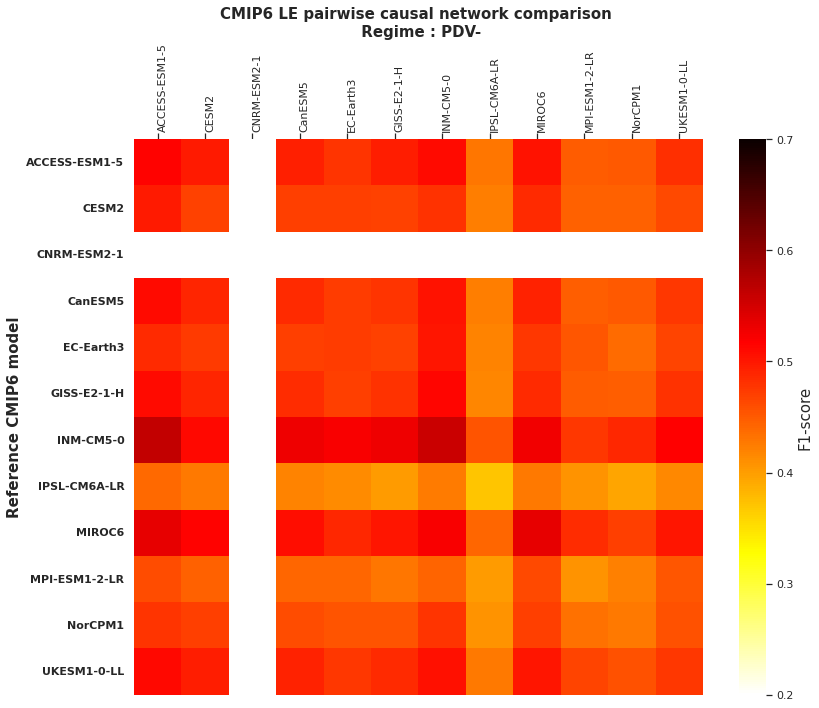

Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') ACCESS-ESM1-5
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') CESM2
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') CNRM-ESM2-1
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') CanESM5
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') EC-Earth3
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') GISS-E2-1-H
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') INM-CM5-0
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') IPSL-CM6A-LR
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') MIROC6
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') MPI-ESM1-2-LR
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') NorCPM1
Failed pcmci on this simulation on regime  InPhase ('CESM2', 'r9i1p1f1') UKESM1-0-L

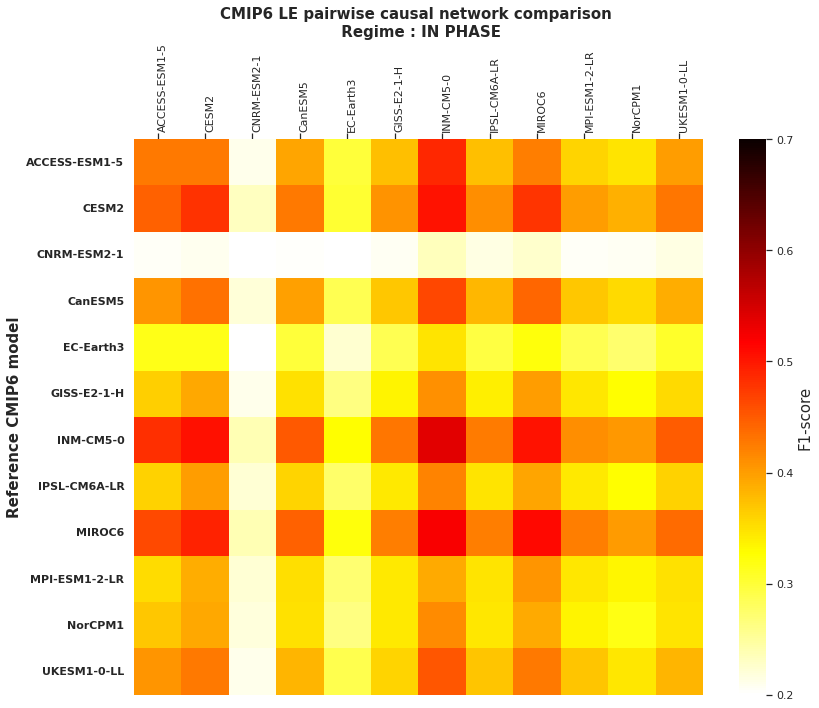

Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') ACCESS-ESM1-5
Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') CESM2
Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') CNRM-ESM2-1
Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') CanESM5
Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') EC-Earth3
Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') GISS-E2-1-H
Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') INM-CM5-0
Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') IPSL-CM6A-LR
Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') MIROC6
Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') MPI-ESM1-2-LR
Failed pcmci on this simulation on regime  outphase ('EC-Earth3', 'r14i1p1f1') NorCPM1
Failed pcmci on t

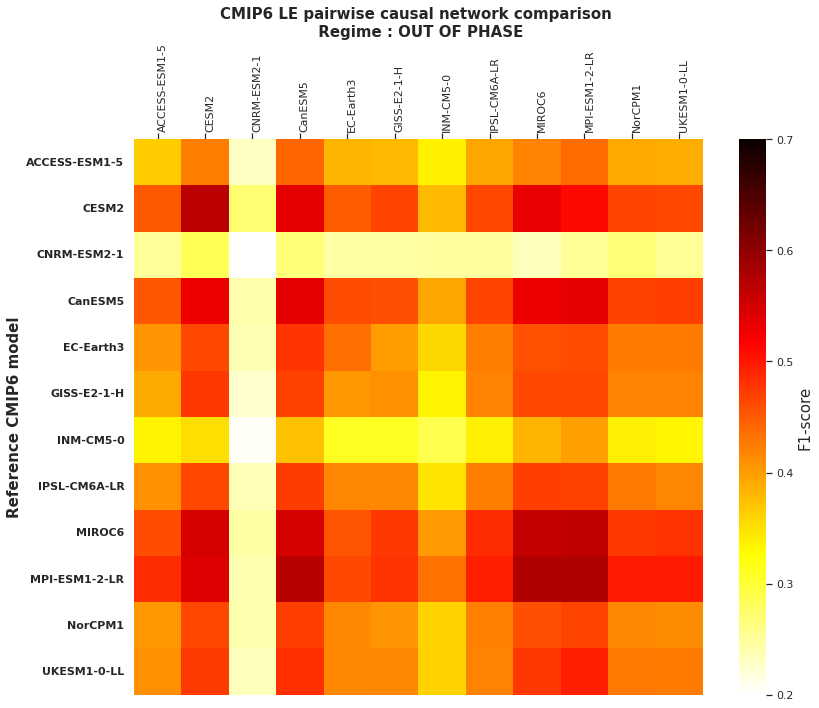

Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') ACCESS-ESM1-5
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') CESM2
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') CNRM-ESM2-1
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') CanESM5
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') EC-Earth3
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') GISS-E2-1-H
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') INM-CM5-0
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') IPSL-CM6A-LR
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') MIROC6
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') MPI-ESM1-2-LR
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2', 'r11i1p1f1') NorCPM1
Failed pcmci on this simulation on regime  PDVpAMVp ('CESM2',

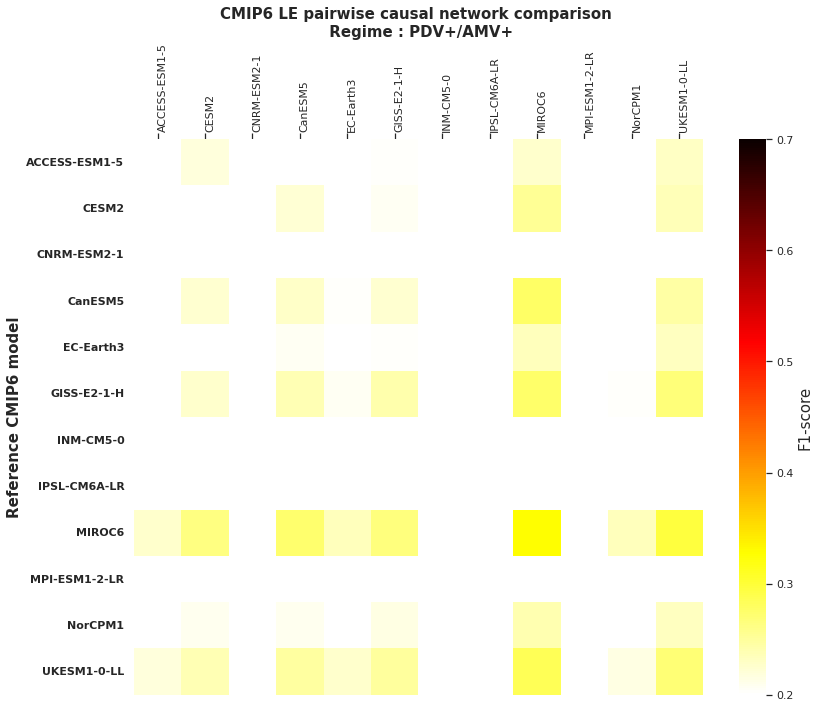

Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') ACCESS-ESM1-5
Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') CESM2
Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') CNRM-ESM2-1
Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') CanESM5
Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') EC-Earth3
Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') GISS-E2-1-H
Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') INM-CM5-0
Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') IPSL-CM6A-LR
Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') MIROC6
Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') MPI-ESM1-2-LR
Failed pcmci on this simulation on regime  PDVpAMVm ('CNRM-ESM2-1', 'r5i1p1f2') NorCPM1
Failed

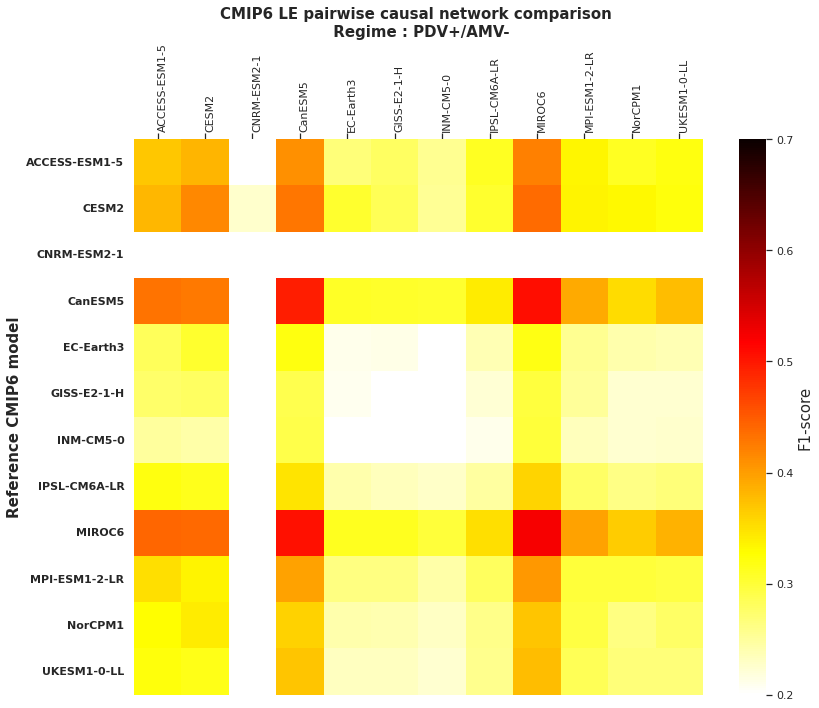

Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i1p1f1') ACCESS-ESM1-5
Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i1p1f1') CESM2
Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i1p1f1') CNRM-ESM2-1
Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i1p1f1') CanESM5
Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i1p1f1') EC-Earth3
Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i1p1f1') GISS-E2-1-H
Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i1p1f1') INM-CM5-0
Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i1p1f1') IPSL-CM6A-LR
Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i1p1f1') MIROC6
Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i1p1f1') MPI-ESM1-2-LR
Failed pcmci on this simulation on regime  PDVmAMVp ('ACCESS-ESM1-5', 'r5i

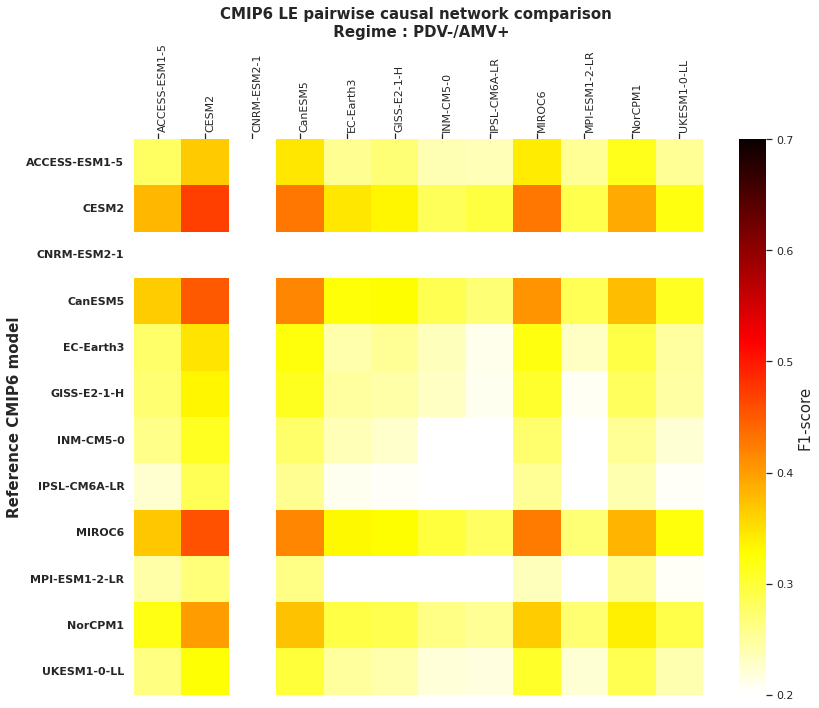

Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM1-5', 'r10i1p1f1') ACCESS-ESM1-5
Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM1-5', 'r10i1p1f1') CESM2
Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM1-5', 'r10i1p1f1') CNRM-ESM2-1
Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM1-5', 'r10i1p1f1') CanESM5
Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM1-5', 'r10i1p1f1') EC-Earth3
Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM1-5', 'r10i1p1f1') GISS-E2-1-H
Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM1-5', 'r10i1p1f1') INM-CM5-0
Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM1-5', 'r10i1p1f1') IPSL-CM6A-LR
Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM1-5', 'r10i1p1f1') MIROC6
Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM1-5', 'r10i1p1f1') MPI-ESM1-2-LR
Failed pcmci on this simulation on regime  PDVmAMVm ('ACCESS-ESM

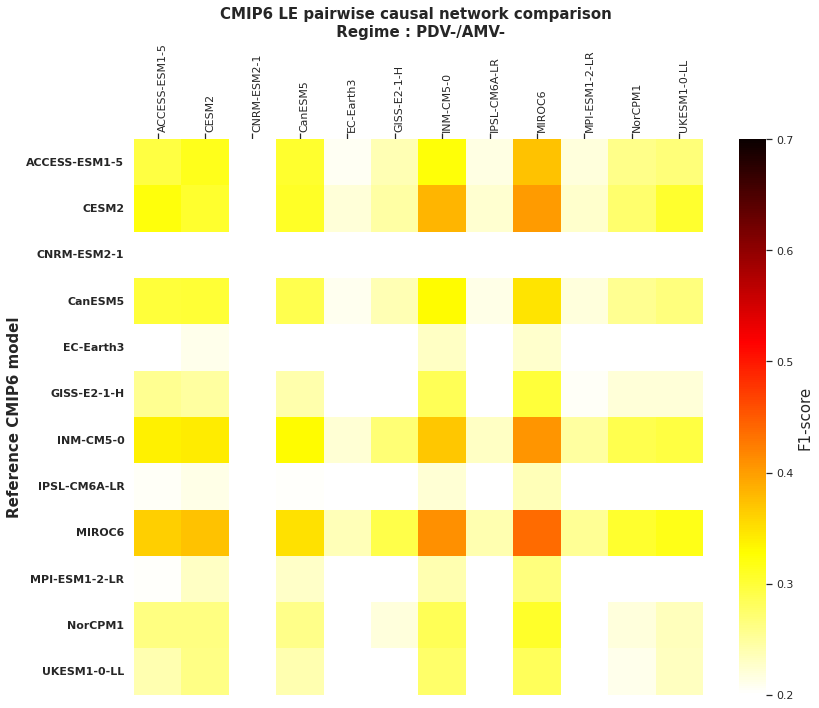

In [28]:
new_dic_keys={'No_mask':'Complete period', 'AMV+': 'AMV+', 'PDV+':'PDV+','AMV-': 'AMV-',\
              'PDV-':'PDV-', 'InPhase':'IN PHASE','outphase':'OUT OF PHASE','PDVpAMVp':'PDV+/AMV+',\
              'PDVpAMVm':'PDV+/AMV-','PDVmAMVp':'PDV-/AMV+','PDVmAMVm':'PDV-/AMV-'}

for regime in f1_matrix.keys():
    tesr_f1_matrix=f1_matrix[regime]
    
    reformed_dict = {}
    for outerKey, innerDict in tesr_f1_matrix.items():
        for innerKey, values in innerDict.items():
            reformed_dict[(outerKey,
                           innerKey)] = values
            
    multiIndex_df = pd.DataFrame(reformed_dict)
    multiIndex_df=multiIndex_df.transpose()
    for ref in list(multiIndex_df.index):
        for comp in list(multiIndex_df.loc[ref].keys()):
            #print(comp)
            try:
                mean_ens = np.mean(list(multiIndex_df.loc[ref, comp].values()))
                multiIndex_df.loc[ref, comp]=mean_ens
            except:
                print('Failed pcmci on this simulation on regime ',regime, ref, comp)
             
            
    multiIndex_df = multiIndex_df.rename_axis(['CMIP6','ensemble_member'])
    avr= multiIndex_df.droplevel(level=1)
    for col in list(avr.columns):
        avr[col] = pd.to_numeric(avr[col], downcast="float")
        
    avr.groupby(level=0).agg(['mean'])


    resulttable_calc = avr.groupby(level=0)
    group_result = resulttable_calc.agg({'ACCESS-ESM1-5':'mean','CESM2':'mean','CNRM-ESM2-1':'mean','CanESM5':'mean', \
                                         'EC-Earth3':'mean','GISS-E2-1-H':'mean','INM-CM5-0':'mean','IPSL-CM6A-LR':'mean',\
                                         'MIROC6':'mean','MPI-ESM1-2-LR':'mean','NorCPM1':'mean','UKESM1-0-LL':'mean'})


    cmap = plt.cm.get_cmap('hot_r')
    fig = plt.figure(figsize=(12,10))
    g = sns.heatmap(group_result, cmap=cmap,annot=False, robust=True, fmt="f", vmin=0.2, vmax=0.7)
    g.xaxis.set_ticks_position("top")
    g.collections[0].colorbar.set_label("F1-score",fontsize=15)
    g.set_title('CMIP6 LE pairwise causal network comparison \n Regime : '+str(new_dic_keys[regime]), fontsize=15, weight="bold")
    g.set_ylabel('Reference CMIP6 model',fontsize=15,weight="bold")
    #g.set_xlabel('CMIP6 Model',fontsize=15,weight="bold")
    g.tick_params(axis='x', which='major', pad=4)  # move the tick labels

    g.set_xticklabels(g.get_xticklabels(),fontsize=11 ,rotation="90",verticalalignment= 'baseline',horizontalalignment= "left")
    g.set_yticklabels(g.get_xticklabels(),fontsize=11,weight="bold")
    plt.tight_layout()
    plt.savefig('Results_DIR/'+str(regime)+'_paiwaise_f1_matrix.png', dpi=300)
    plt.show()
